In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from IPython.display import display

# Add your project paths
sys.path.append("../scripts")
sys.path.append("../utility")
from network import KoopmanNet

# ----------------------------
# Project settings
# ----------------------------
project_name = "Aug_8"
gamma        = 0.8
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ksteps       = 15
normalize    = 'nonorm'  # global default; overridden per env below

# ----------------------------
# NEW: How to interpret encode_dims
#   - "multiplier": values in encode_dims are multipliers of state_dim (old behavior)
#   - "absolute":   values in encode_dims are the actual latent sizes
# ----------------------------
encode_dim_mode = "multiplier"  # <-- set to "absolute" to use actual latent dims

# ----------------------------
# Hyper-parameter lists
# ----------------------------
envs         = ['Kinova']#['DampingPendulum', 'Franka', 'DoublePendulum', 'Polynomial', 'G1', 'Go2', 'Kinova']
encode_dims  = [1, 2, 4, 8, 16]  # Interpreted per encode_dim_mode
cov_regs     = [0, 1]
ctrl_regs    = [0, 1]
seeds        = [17382, 76849, 20965, 84902, 51194]
m = 100

# ----------------------------
# U_dim mapping (known actuated DOFs)
# ----------------------------
u_dim_map = {
    "Franka": 7,
    "DoublePendulum": 2,
    "DampingPendulum": 1,
    "G1": 23,
    "Go2": 12,
    "Kinova": 7  # <-- adjust if different for your Kinova dataset
}

# ----------------------------
# Normalization override: force "norm" for G1, Go2
# ----------------------------
normalize_override = {
    "G1": "norm",
    "Go2": "norm",
}

# ----------------------------
# Helper: dataset path builder
# ----------------------------
def build_dataset_path(env: str, normalize_default: str, ksteps_val: int, m_val: int):
    """
    Build dataset path using per-env normalization override.
    """
    normalize_used = normalize_override.get(env, normalize_default)
    if env == "Polynomial":
        return os.path.join(
            "..", "data", "datasets",
            f"dataset_{env}_{normalize_used}_m_{m_val}_Ktrain_60000_Kval_20000_Ktest_20000_Ksteps_{ksteps_val}.pt"
        )
    else:
        return os.path.join(
            "..", "data", "datasets",
            f"dataset_{env}_{normalize_used}_Ktrain_60000_Kval_20000_Ktest_20000_Ksteps_{ksteps_val}.pt"
        )

# ----------------------------
# Helpers
# ----------------------------
def _mode_matches(row_mode: str, selected_mode: str) -> bool:
    """
    Map stored CSV 'encode_dim_mode' to our selection. Backward-compatible if column missing.
    CSV values from the training script: 'times_input_dim' or 'absolute'.
    We'll also accept 'per_state' for compatibility with earlier naming.
    """
    if row_mode is None or row_mode == "" or pd.isna(row_mode):
        # No mode stored -> accept in both cases for backward-compat
        return True
    row_mode = str(row_mode).strip().lower()
    selected_mode = selected_mode.strip().lower()
    if selected_mode == "multiplier":
        return row_mode in ("times_input_dim", "per_state")
    elif selected_mode == "absolute":
        return row_mode == "absolute"
    return True

def evaluate_model(model, data, u_dim, gamma, state_dim, device):
    model.eval()
    with torch.no_grad():
        steps = data.shape[0]
        if u_dim is None:
            X = model.encode(data[0].to(device))
        else:
            X = model.encode(data[0, :, u_dim:].to(device))
        encoded_initial = X[:, state_dim:]

        weighted_loss = 0.0
        beta, beta_sum = 1.0, 0.0
        step_errors = []

        for i in range(steps - 1):
            if u_dim is None:
                X      = model.forward(X, None)
                target = data[i + 1].to(device)
            else:
                X      = model.forward(X, data[i, :, :u_dim].to(device))
                target = data[i + 1, :, u_dim:].to(device)

            error = nn.MSELoss()(X[:, :state_dim], target)
            step_errors.append(error.item())
            weighted_loss += beta * error
            beta_sum      += beta
            beta         *= gamma

        weighted_loss /= beta_sum

        # covariance loss on the initial encoding
        z           = encoded_initial
        z_centered  = z - z.mean(dim=0, keepdim=True)
        cov_matrix  = (z_centered.t() @ z_centered) / (z_centered.size(0) - 1)
        off_diag    = cov_matrix - torch.diag(torch.diag(cov_matrix))
        cov_loss    = torch.norm(off_diag, p='fro') ** 2
        encode_dim  = X.shape[1] - state_dim
        normalized_cov_loss = (
            cov_loss.item() / (encode_dim * (encode_dim - 1))
            if encode_dim > 1 else cov_loss.item()
        )

    return weighted_loss.item(), step_errors, normalized_cov_loss

# ----------------------------------------------------------------------
# 1. Load CSV log
# ----------------------------------------------------------------------
csv_log_path = os.path.join("..", "log", project_name, "koopman_results_log.csv")
assert os.path.exists(csv_log_path), f"CSV log not found: {csv_log_path}"

log_df = pd.read_csv(csv_log_path)

# Back-compat: ensure required columns exist/castable
if "use_covariance_loss" in log_df.columns:
    log_df["use_covariance_loss"] = log_df["use_covariance_loss"].astype(int)
if "use_control_loss" in log_df.columns:
    log_df["use_control_loss"] = log_df["use_control_loss"].astype(int)

# Ensure consistent dtypes for filtering
cast_cols = {
    "env_name": str,
    "encode_dim": int,
    "seed": int,
    "model_path": str,
}
for k, t in cast_cols.items():
    if k in log_df.columns:
        log_df[k] = log_df[k].astype(t)

# ----------------------------------------------------------------------
# 2. Dynamically detect state_dims and allowed encode_dims
# ----------------------------------------------------------------------
encode_dims_allowed = {}  # env -> list of actual latent sizes (ints)

for env in envs:
    Ksteps_env = 1 if env == "Polynomial" else ksteps
    dataset_path = build_dataset_path(env, normalize, Ksteps_env, m)

    if os.path.exists(dataset_path):
        data_dict = torch.load(dataset_path, weights_only=False)
        full_dim = data_dict["Ktest_data"].shape[2]
        u_dim = u_dim_map.get(env, 0)
        state_dim = full_dim - u_dim

        if encode_dim_mode == "multiplier":
            encode_dims_allowed[env] = [mult * state_dim for mult in encode_dims]
        else:  # "absolute"
            encode_dims_allowed[env] = list(encode_dims)
    else:
        # If dataset missing: fall back based on mode
        encode_dims_allowed[env] = [m for m in encode_dims] if encode_dim_mode == "absolute" else list(encode_dims)

# ----------------------------------------------------------------------
# 3. Filter log_df using detected encode_dims AND (if present) the mode
# ----------------------------------------------------------------------
filtered_df = log_df[
    log_df.apply(
        lambda r: (
            r.get("env_name") in envs and
            # r["encode_dim"] in CSV is the ACTUAL latent size used
            (r.get("encode_dim") in encode_dims_allowed.get(r.get("env_name"), [])) and
            (r.get("seed") in seeds) and
            (r.get("use_covariance_loss") in cov_regs if "use_covariance_loss" in r.index else True) and
            (r.get("use_control_loss") in ctrl_regs if "use_control_loss" in r.index else True) and
            _mode_matches(r.get("encode_dim_mode", None), encode_dim_mode)
        ),
        axis=1
    )
]

# Debug if empty
if filtered_df.empty:
    print("[Error] No models found after filtering.")
    print("Available envs in log:", sorted(log_df["env_name"].unique()))
    print("Allowed encode dims per env:")
    for e, dims in encode_dims_allowed.items():
        print(f"  {e}: {dims}")
    print("Available encode_dims in log:", sorted(log_df["encode_dim"].unique()))
    if "encode_dim_mode" in log_df.columns:
        print("Available encode_dim_mode:", sorted(log_df["encode_dim_mode"].astype(str).unique()))
    print("Available seeds:", sorted(log_df["seed"].unique()))
    if "use_covariance_loss" in log_df.columns:
        print("Available use_covariance_loss:", sorted(log_df["use_covariance_loss"].unique()))
    if "use_control_loss" in log_df.columns:
        print("Available use_control_loss:", sorted(log_df["use_control_loss"].unique()))
    os.makedirs(project_name, exist_ok=True)
    pd.DataFrame(columns=[
        "Environment", "EncodeDim", "UseCovLoss", "UseControlLoss",
        "WeightedError", "NormalizedCovLoss"
    ]).to_csv(os.path.join(project_name, "evaluation_summary.csv"), index=False)
    sys.exit(0)

# ----------------------------------------------------------------------
# 4. Build results dict
# ----------------------------------------------------------------------
results = {}
for _, row in filtered_df.iterrows():
    key = (row["env_name"], row["encode_dim"], row.get("use_covariance_loss", 0), row.get("use_control_loss", 0))
    results.setdefault(key, []).append((int(row["seed"]), row["model_path"]))

# ----------------------------------------------------------------------
# 5. Evaluate & aggregate metrics
# ----------------------------------------------------------------------
agg_metrics = {}
step_error_curves_agg = {}

for env in envs:
    Ksteps_env = 1 if env == "Polynomial" else ksteps
    dataset_path = build_dataset_path(env, normalize, Ksteps_env, m)

    if not os.path.exists(dataset_path):
        print(f"[Warning] Missing dataset for {env}, skipping.")
        continue

    data_dict = torch.load(dataset_path, weights_only=False)
    test_data = torch.from_numpy(data_dict["Ktest_data"]).float().to(device)

    u_dim = u_dim_map.get(env, None)
    if u_dim is not None:
        state_dim = test_data.shape[2] - u_dim
    else:
        state_dim = test_data.shape[2]

    for key, checkpoints in results.items():
        if key[0] != env:
            continue
        _, enc_dim, cov_reg, ctrl_reg = key

        w_errs, cov_losses, all_step_errs = [], [], []
        for seed_val, path in checkpoints:
            if not os.path.exists(path):
                print(f"[Warning] Missing checkpoint: {path}")
                continue

            chkpt  = torch.load(path, map_location=device, weights_only=False)
            layers = chkpt['layer']
            Nkoop  = state_dim + enc_dim
            model  = KoopmanNet(layers, Nkoop, u_dim).to(device)
            model.load_state_dict(chkpt['model'])

            w_err, steps, c_loss = evaluate_model(model, test_data, u_dim, gamma, state_dim, device)
            w_errs.append(w_err)
            cov_losses.append(c_loss)
            all_step_errs.append(np.array(steps))

        if not w_errs:
            continue

        w_log = np.log(np.array(w_errs))
        c_log = np.log(np.array(cov_losses) + 1e-12)
        agg_metrics[key] = {
            "WeightedError_mean":     float(np.exp(w_log.mean())),
            "NormalizedCovLoss_mean": float(np.exp(c_log.mean()))
        }

        arr     = np.stack(all_step_errs, axis=0)
        log_arr = np.log(arr + 1e-12)
        mean_curve  = np.exp(log_arr.mean(axis=0))
        lower_curve = np.exp(log_arr.mean(axis=0) - log_arr.std(axis=0))
        upper_curve = np.exp(log_arr.mean(axis=0) + log_arr.std(axis=0))

        step_error_curves_agg[key] = {"mean": mean_curve, "lower": lower_curve, "upper": upper_curve}

# ----------------------------------------------------------------------
# 6. Save df_summary
# ----------------------------------------------------------------------
rows = []
for (env, enc_dim, cov_reg, ctrl_reg), metrics in agg_metrics.items():
    rows.append({
        "Environment":       env,
        "EncodeDim":         enc_dim,
        "UseCovLoss":        cov_reg,
        "UseControlLoss":    ctrl_reg,
        "WeightedError":     metrics["WeightedError_mean"],
        "NormalizedCovLoss": metrics["NormalizedCovLoss_mean"]
    })

df_summary = pd.DataFrame(rows)
os.makedirs(project_name, exist_ok=True)
summary_path = os.path.join(project_name, "evaluation_summary.csv")
df_summary.to_csv(summary_path, index=False)
print(f"Saved summary to {summary_path}")
display(df_summary)

# ----------------------------------------------------------------------
# 7. Collapse curves for plotting (control off)
# ----------------------------------------------------------------------
plot_curves = {}
for (env, enc_dim, cov_reg, ctrl_reg), curves in step_error_curves_agg.items():
    if ctrl_reg != 0:
        continue
    plot_curves[(env, enc_dim, cov_reg)] = curves
step_error_curves_agg = plot_curves

# ----------------------------------------------------------------------
# 8. Plot multi-step error curves
# ----------------------------------------------------------------------
for env in envs:
    if env == "Polynomial":
        continue

    out_dir = os.path.join(project_name, env)
    os.makedirs(out_dir, exist_ok=True)

    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = cm.get_cmap('tab10', len(encode_dims))

    dim_handles = []
    for i, val in enumerate(encode_dims):
        # Map user list to actual dims per env
        if env in encode_dims_allowed and encode_dims_allowed[env]:
            actual_dim = encode_dims_allowed[env][i] if i < len(encode_dims_allowed[env]) else None
        else:
            actual_dim = val

        if actual_dim is None:
            continue

        color = cmap(i)
        if encode_dim_mode == "multiplier":
            label = f"x{val} ({actual_dim})"
        else:  # absolute
            label = f"{actual_dim}"

        dim_handles.append(mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=label))

        for cov_val in cov_regs:
            key = (env, actual_dim, cov_val)
            if key not in step_error_curves_agg:
                continue
            steps     = np.arange(1, len(step_error_curves_agg[key]["mean"]) + 1)
            linestyle = '-' if cov_val == 0 else '--'
            ax.plot(steps, step_error_curves_agg[key]["mean"], marker='o', color=color, linestyle=linestyle)

    cov_handles = [
        mlines.Line2D([], [], color='black', linestyle='-',  label='Cov off'),
        mlines.Line2D([], [], color='black', linestyle='--', label='Cov on')
    ]

    leg1 = ax.legend(handles=dim_handles, loc='upper left', bbox_to_anchor=(0, 1), title='Encode Dim')
    ax.add_artist(leg1)
    leg2 = ax.legend(handles=cov_handles, loc='upper left', bbox_to_anchor=(0.25, 1), title='Covariance')
    ax.add_artist(leg2)

    ax.set_xlabel("Step")
    ax.set_ylabel("Prediction Error (MSE, log scale)")
    ax.set_yscale('log')
    ax.set_title(f"Multi-step Error Curves — {env} ({encode_dim_mode})")
    ax.grid(True, which="both", ls="--")
    fig.tight_layout()

    png_path = os.path.join(out_dir, f"MultiStepError_{env}_{encode_dim_mode}.png")
    plt.savefig(png_path, dpi=300)
    print(f"Saved plot: {png_path}")
    plt.close(fig)

# ----------------------------------------------------------------------
# 9. Env-specific improvement table
# ----------------------------------------------------------------------
if df_summary.empty:
    print("[Skip] No environment loss effect table — df_summary is empty.")
else:
    env_results = []
    for env, env_df in df_summary.groupby("Environment"):
        cov_diffs, ctrl_diffs, both_diffs = [], [], []
        cov_percs, ctrl_percs, both_percs = [], [], []

        for enc_dim in env_df['EncodeDim'].unique():
            sub_df = env_df[env_df['EncodeDim'] == enc_dim]
            base_row = sub_df[(sub_df['UseCovLoss'] == 0) & (sub_df['UseControlLoss'] == 0)]
            base_val = base_row['WeightedError'].values[0] if len(base_row) == 1 else None

            cov_row = sub_df[(sub_df['UseCovLoss'] == 1) & (sub_df['UseControlLoss'] == 0)]
            if base_val is not None and len(cov_row) == 1:
                val = cov_row['WeightedError'].values[0]
                cov_diffs.append(base_val - val)
                cov_percs.append((base_val - val) / base_val * 100)

            ctrl_row = sub_df[(sub_df['UseCovLoss'] == 0) & (sub_df['UseControlLoss'] == 1)]
            if base_val is not None and len(ctrl_row) == 1:
                val = ctrl_row['WeightedError'].values[0]
                ctrl_diffs.append(base_val - val)
                ctrl_percs.append((base_val - val) / base_val * 100)

            both_row = sub_df[(sub_df['UseCovLoss'] == 1) & (sub_df['UseControlLoss'] == 1)]
            if base_val is not None and len(both_row) == 1:
                val = both_row['WeightedError'].values[0]
                both_diffs.append(base_val - val)
                both_percs.append((base_val - val) / base_val * 100)

        env_results.append({
            "Environment": env,
            "CovLoss_AbsImprovement": np.mean(cov_diffs) if cov_diffs else np.nan,
            "CovLoss_%Improvement": np.mean(cov_percs) if cov_percs else np.nan,
            "CtrlLoss_AbsImprovement": np.mean(ctrl_diffs) if ctrl_diffs else np.nan,
            "CtrlLoss_%Improvement": np.mean(ctrl_percs) if ctrl_percs else np.nan,
            "BothLoss_AbsImprovement": np.mean(both_diffs) if both_diffs else np.nan,
            "BothLoss_%Improvement": np.mean(both_percs) if both_percs else np.nan,
        })

    env_effect_df = pd.DataFrame(env_results)
    print("Environment-specific average WeightedError improvement:")
    print(env_effect_df.to_string(index=False, float_format="%.6f"))
    env_effect_df.to_csv(f"{project_name}/environment_loss_effects_{encode_dim_mode}.csv", index=False)

Saved summary to Aug_8/evaluation_summary.csv


,Environment,EncodeDim,UseCovLoss,UseControlLoss,WeightedError,NormalizedCovLoss
0,Kinova,14,0,0,0.236689,2.324351
1,Kinova,14,1,0,0.242036,0.000066
2,Kinova,14,0,1,0.279601,8.607488
3,Kinova,14,1,1,0.274032,0.000486
4,Kinova,28,0,0,0.151817,165.477864
5,Kinova,28,1,0,0.157657,0.000280
6,Kinova,28,0,1,0.180005,10.579233
7,Kinova,28,1,1,0.175605,0.000662
8,Kinova,56,0,0,0.066363,6.064864
9,Kinova,56,1,0,0.070777,0.000277


/tmp/ipykernel_1153257/2069542663.py:347: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(encode_dims))


Saved plot: Aug_8/Kinova/MultiStepError_Kinova_multiplier.png
Environment-specific average WeightedError improvement:
Environment  CovLoss_AbsImprovement  CovLoss_%Improvement  CtrlLoss_AbsImprovement  CtrlLoss_%Improvement  BothLoss_AbsImprovement  BothLoss_%Improvement
     Kinova               -0.003387             -6.500475                -0.019713            -140.670379                -0.016489            -116.020179


In [3]:
import pandas as pd
project_name = "Aug_8"

In [ ]:
damping_pendulum = pd.read_csv(f'../log/{project_name}/control_results/DampingPendulum.csv')
double_pendulum = pd.read_csv(f'../log/{project_name}/control_results/DoublePendulum.csv')
franka = pd.read_csv(f'../log/{project_name}/control_results/Franka.csv')
g1 = pd.read_csv(f'../log/{project_name}/control_results/G1.csv')
go2 = pd.read_csv(f'../log/{project_name}/control_results/Go2.csv')

In [13]:
damping_pendulum_df = damping_pendulum[damping_pendulum['use_control_loss'] == False]
damping_pendulum_df

,env_name,encode_dim,use_control_loss,use_covariance_loss,stability_rate,error,control_cost
0,DampingPendulum,2,False,False,1.0,1.060279,537.322711
1,DampingPendulum,2,False,True,1.0,1.122041,469.532518
4,DampingPendulum,4,False,False,1.0,1.086285,522.404276
5,DampingPendulum,4,False,True,1.0,1.109370,529.853226
8,DampingPendulum,8,False,False,1.0,0.974036,2330.552300
9,DampingPendulum,8,False,True,1.0,1.062659,6932.705090
12,DampingPendulum,16,False,False,1.0,0.687357,23810.884418
13,DampingPendulum,16,False,True,1.0,0.006038,3094.608820
16,DampingPendulum,32,False,False,1.0,0.201702,1234.264073
17,DampingPendulum,32,False,True,1.0,1.024192,519.011944


   encode_dim  use_covariance_loss  mean_error  median_error  \
0           2                False    1.060279      1.060279   
1           2                 True    1.122041      1.122041   
2           4                False    1.086285      1.086285   
3           4                 True    1.109370      1.109370   
4           8                False    0.974036      0.974036   
5           8                 True    1.062659      1.062659   
6          16                False    0.687357      0.687357   
7          16                 True    0.006038      0.006038   
8          32                False    0.201702      0.201702   
9          32                 True    1.024192      1.024192   

   mean_control_cost  
0         537.322711  
1         469.532518  
2         522.404276  
3         529.853226  
4        2330.552300  
5        6932.705090  
6       23810.884418  
7        3094.608820  
8        1234.264073  
9         519.011944  
   encode_dim  use_covariance_loss  mean_e

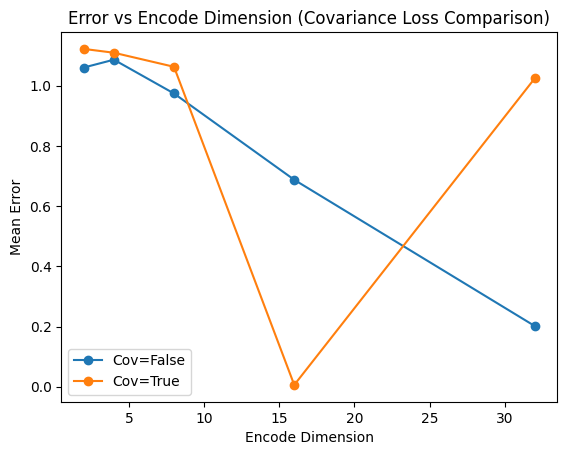

In [15]:
summary = damping_pendulum_df.groupby(["encode_dim", "use_covariance_loss"]).agg(
    mean_error=("error", "mean"),
    median_error=("error", "median"),
    mean_control_cost=("control_cost", "mean")
).reset_index()

print(summary)

# Compute relative improvement compared to baseline (encode_dim=2, covariance=False)
baseline_error = damping_pendulum_df[(damping_pendulum_df["encode_dim"]==2) & (damping_pendulum_df["use_covariance_loss"]==False)]["error"].mean()

summary["error_improvement_%"] = 100 * (baseline_error - summary["mean_error"]) / baseline_error

print(summary)

import matplotlib.pyplot as plt

for cov in [False, True]:
    subset = summary[summary["use_covariance_loss"]==cov]
    plt.plot(subset["encode_dim"], subset["mean_error"], marker="o", label=f"Cov={cov}")

plt.xlabel("Encode Dimension")
plt.ylabel("Mean Error")
plt.title("Error vs Encode Dimension (Covariance Loss Comparison)")
plt.legend()
plt.show()

In [16]:
double_pendulum_df = double_pendulum[double_pendulum['use_control_loss'] == False]
double_pendulum_df

,env_name,encode_dim,use_control_loss,use_covariance_loss,stability_rate,error,control_cost
0,DoublePendulum,4,False,False,1.000000,0.090881,800.070908
1,DoublePendulum,4,False,True,1.000000,0.119440,234.228067
4,DoublePendulum,8,False,False,1.000000,0.072447,424.839857
5,DoublePendulum,8,False,True,1.000000,0.149326,130.043557
8,DoublePendulum,16,False,False,1.000000,0.086320,327.925644
9,DoublePendulum,16,False,True,1.000000,0.078747,233.972275
12,DoublePendulum,32,False,False,1.000000,0.638414,2159.581370
13,DoublePendulum,32,False,True,1.000000,0.305542,135.826770
16,DoublePendulum,64,False,False,0.666667,0.078720,35091.523292
17,DoublePendulum,64,False,True,1.000000,0.022713,742.706018


   encode_dim  use_covariance_loss  mean_error  median_error  \
0           4                False    0.090881      0.090881   
1           4                 True    0.119440      0.119440   
2           8                False    0.072447      0.072447   
3           8                 True    0.149326      0.149326   
4          16                False    0.086320      0.086320   
5          16                 True    0.078747      0.078747   
6          32                False    0.638414      0.638414   
7          32                 True    0.305542      0.305542   
8          64                False    0.078720      0.078720   
9          64                 True    0.022713      0.022713   

   mean_control_cost  
0         800.070908  
1         234.228067  
2         424.839857  
3         130.043557  
4         327.925644  
5         233.972275  
6        2159.581370  
7         135.826770  
8       35091.523292  
9         742.706018  
   encode_dim  use_covariance_loss  mean_e

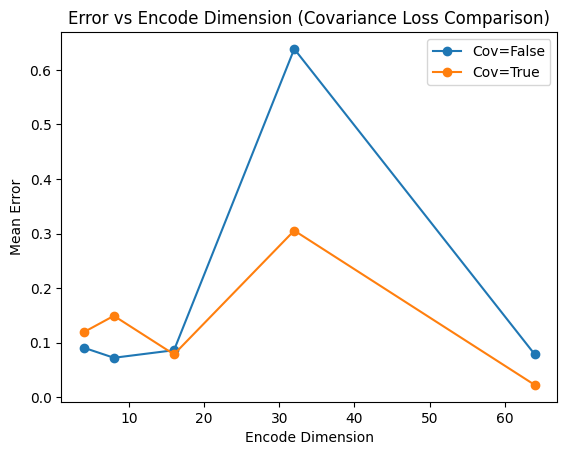

In [17]:
summary = double_pendulum_df.groupby(["encode_dim", "use_covariance_loss"]).agg(
    mean_error=("error", "mean"),
    median_error=("error", "median"),
    mean_control_cost=("control_cost", "mean")
).reset_index()

print(summary)

# Compute relative improvement compared to baseline (encode_dim=2, covariance=False)
baseline_error = double_pendulum_df[(double_pendulum_df["encode_dim"]==2) & (double_pendulum_df["use_covariance_loss"]==False)]["error"].mean()

summary["error_improvement_%"] = 100 * (baseline_error - summary["mean_error"]) / baseline_error

print(summary)

import matplotlib.pyplot as plt

for cov in [False, True]:
    subset = summary[summary["use_covariance_loss"]==cov]
    plt.plot(subset["encode_dim"], subset["mean_error"], marker="o", label=f"Cov={cov}")

plt.xlabel("Encode Dimension")
plt.ylabel("Mean Error")
plt.title("Error vs Encode Dimension (Covariance Loss Comparison)")
plt.legend()
plt.show()

In [20]:
franka_df = franka[franka['use_control_loss'] == False].drop(columns=['error_eight.1', 'error_star.1'])
franka_df

,env_name,encode_dim,use_control_loss,use_covariance_loss,error_eight,error_star
1,Franka,17.0,False,False,2.0647015766666668,2.0972259466666667
2,Franka,17.0,False,True,3.6882797333333333,3.20513298
5,Franka,34.0,False,False,9.632856776666666,9.906438213333333
6,Franka,34.0,False,True,3.015361756666666,2.5135756733333334
9,Franka,68.0,False,False,4.270442546666667,6.349508240000001
10,Franka,68.0,False,True,1.4492051533333334,9.42135324
13,Franka,136.0,False,False,7.21708715,10.335668436666667
14,Franka,136.0,False,True,0.9236492766666666,0.8150126700000001
17,Franka,272.0,False,False,0.9847558833333334,0.9528056166666667
18,Franka,272.0,False,True,1.1243038633333333,1.0447324866666665


   env_name  encode_dim use_control_loss use_covariance_loss  error_eight  \
1    Franka        17.0            False               False     2.064702   
2    Franka        17.0            False                True     3.688280   
5    Franka        34.0            False               False     9.632857   
6    Franka        34.0            False                True     3.015362   
9    Franka        68.0            False               False     4.270443   
10   Franka        68.0            False                True     1.449205   
13   Franka       136.0            False               False     7.217087   
14   Franka       136.0            False                True     0.923649   
17   Franka       272.0            False               False     0.984756   
18   Franka       272.0            False                True     1.124304   

    error_star  eight_error_improvement_%  star_error_improvement_%  
1     2.097226                   0.000000                  0.000000  
2     3.2051

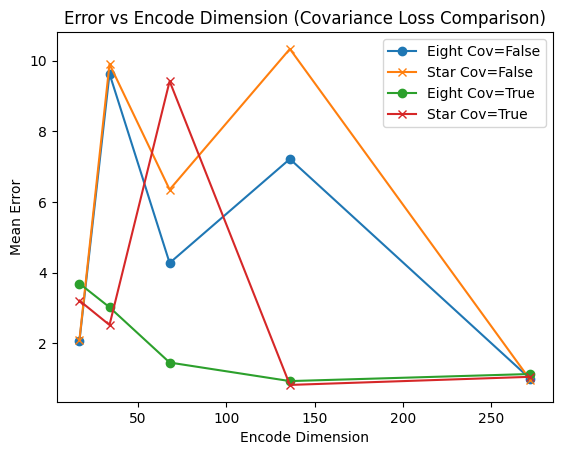

In [26]:
summary = franka_df.copy()

# Ensure numeric dtype
summary["error_eight"] = pd.to_numeric(summary["error_eight"], errors="coerce")
summary["error_star"]  = pd.to_numeric(summary["error_star"], errors="coerce")

# Baselines
baseline_eight_error = summary[(summary["encode_dim"]==17) & (summary["use_covariance_loss"]==False)]["error_eight"].mean()
baseline_star_error  = summary[(summary["encode_dim"]==17) & (summary["use_covariance_loss"]==False)]["error_star"].mean()

# Improvement %
summary["eight_error_improvement_%"] = 100 * (baseline_eight_error - summary["error_eight"]) / baseline_eight_error
summary["star_error_improvement_%"]  = 100 * (baseline_star_error - summary["error_star"]) / baseline_star_error

print(summary)

# Plot grouped mean errors
grouped = summary.groupby(["encode_dim","use_covariance_loss"]).agg(
    mean_eight_error=("error_eight","mean"),
    mean_star_error=("error_star","mean")
).reset_index()

for cov in [False, True]:
    subset = grouped[grouped["use_covariance_loss"]==cov]
    plt.plot(subset["encode_dim"], subset["mean_eight_error"], marker="o", label=f"Eight Cov={cov}")
    plt.plot(subset["encode_dim"], subset["mean_star_error"], marker="x", label=f"Star Cov={cov}")

plt.xlabel("Encode Dimension")
plt.ylabel("Mean Error")
plt.title("Error vs Encode Dimension (Covariance Loss Comparison)")
plt.legend()
plt.show()

In [28]:
g1_df = g1[g1['use_control_loss'] == False].drop(columns=['mean_JrPE.1', 'mean_survival_steps.1'])
g1_df

,env_name,encode_dim,use_control_loss,use_covariance_loss,mean_JrPE,mean_survival_steps
1,G1,53.0,False,False,0.1408830236634444,62.94766666666666
2,G1,53.0,False,True,0.14029147673607809,63.534
5,G1,106.0,False,False,0.14983538661718296,63.27
6,G1,106.0,False,True,0.1470926981074867,62.56666666666666
9,G1,212.0,False,False,0.1314062360985875,65.37933333333332
10,G1,212.0,False,True,0.13406486882244817,65.94033333333333
13,G1,424.0,False,False,0.11281434038919617,66.92933333333333
14,G1,424.0,False,True,0.12209131128507607,64.699
17,G1,848.0,False,False,0.13597986337554202,66.999
18,G1,848.0,False,True,0.11192293328433289,67.48266666666667


   env_name  encode_dim use_control_loss use_covariance_loss  mean_JrPE  \
1        G1        53.0            False               False   0.140883   
2        G1        53.0            False                True   0.140291   
5        G1       106.0            False               False   0.149835   
6        G1       106.0            False                True   0.147093   
9        G1       212.0            False               False   0.131406   
10       G1       212.0            False                True   0.134065   
13       G1       424.0            False               False   0.112814   
14       G1       424.0            False                True   0.122091   
17       G1       848.0            False               False   0.135980   
18       G1       848.0            False                True   0.111923   

    mean_survival_steps  error_improvement_%  survival_improvement_%  
1             62.947667             0.000000                0.000000  
2             63.534000         

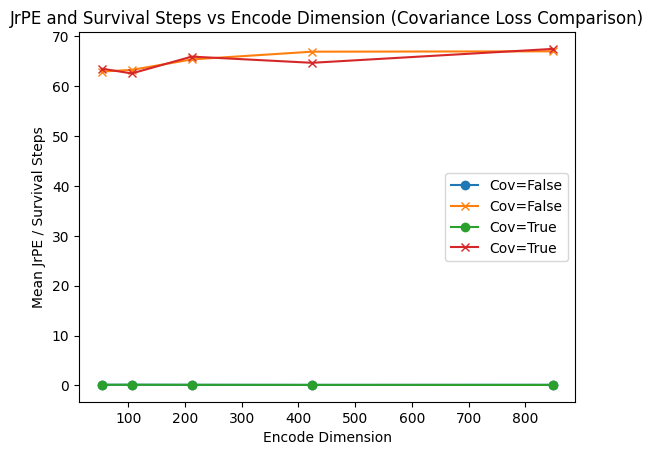

In [34]:
summary = g1_df.copy()

for col in ["encode_dim", "mean_JrPE", "mean_survival_steps"]:
    summary[col] = pd.to_numeric(summary[col], errors="coerce")

# Compute relative improvement compared to baseline (encode_dim=2, covariance=False)
baseline_mean_JrPE = summary[(summary["encode_dim"]==53) & (summary["use_covariance_loss"]==False)]["mean_JrPE"].mean()
baseline_survival_steps = summary[(summary["encode_dim"]==53) & (summary["use_covariance_loss"]==False)]["mean_survival_steps"].mean()

summary["error_improvement_%"] = 100 * (baseline_mean_JrPE - summary["mean_JrPE"]) / baseline_mean_JrPE
summary["survival_improvement_%"] = 100 * (summary["mean_survival_steps"] - baseline_survival_steps) / baseline_survival_steps

print(summary)

import matplotlib.pyplot as plt

for cov in [False, True]:
    subset = summary[summary["use_covariance_loss"]==cov]
    plt.plot(subset["encode_dim"], subset["mean_JrPE"], marker="o", label=f"Cov={cov}")
    plt.plot(subset["encode_dim"], subset["mean_survival_steps"], marker="x", label=f"Cov={cov}")

plt.xlabel("Encode Dimension")
plt.ylabel("Mean JrPE / Survival Steps")
plt.title("JrPE and Survival Steps vs Encode Dimension (Covariance Loss Comparison)")
plt.legend()
plt.show()

In [35]:
go2_df = go2[go2['use_control_loss'] == False].drop(columns=['mean_JrPE.1', 'mean_survival_steps.1'])
go2_df

,env_name,encode_dim,use_control_loss,use_covariance_loss,mean_JrPE,mean_survival_steps
1,Go2,35.0,False,False,0.16379285924839057,16.734666666666666
2,Go2,35.0,False,True,0.16264764089814313,26.711333333333332
5,Go2,70.0,False,False,0.19017719939334543,12.669333333333332
6,Go2,70.0,False,True,0.18044834259200807,11.293
9,Go2,140.0,False,False,0.17828382600720968,15.183666666666667
10,Go2,140.0,False,True,0.15984678752155612,18.013333333333332
13,Go2,280.0,False,False,0.1891349555477705,12.635666666666667
14,Go2,280.0,False,True,0.17716626288424034,13.061333333333332
17,Go2,560.0,False,False,0.18823394363025714,11.975333333333333
18,Go2,560.0,False,True,0.16996049728484694,11.561


   env_name  encode_dim use_control_loss use_covariance_loss  mean_JrPE  \
1       Go2        35.0            False               False   0.163793   
2       Go2        35.0            False                True   0.162648   
5       Go2        70.0            False               False   0.190177   
6       Go2        70.0            False                True   0.180448   
9       Go2       140.0            False               False   0.178284   
10      Go2       140.0            False                True   0.159847   
13      Go2       280.0            False               False   0.189135   
14      Go2       280.0            False                True   0.177166   
17      Go2       560.0            False               False   0.188234   
18      Go2       560.0            False                True   0.169960   

    mean_survival_steps  error_improvement_%  survival_improvement_%  
1             16.734667             0.000000                0.000000  
2             26.711333         

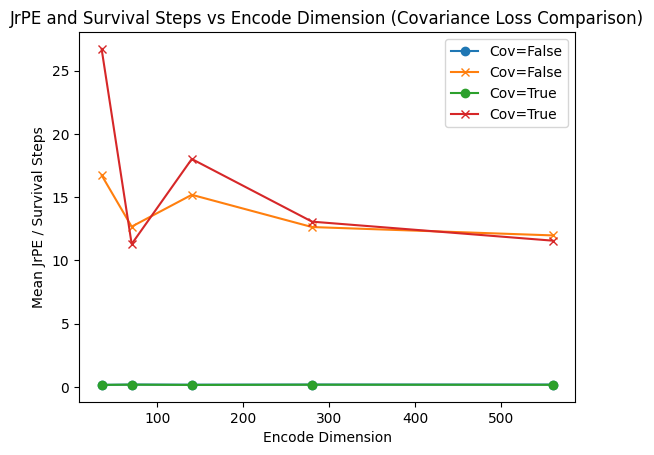

In [37]:
summary = go2_df.copy()

for col in ["encode_dim", "mean_JrPE", "mean_survival_steps"]:
    summary[col] = pd.to_numeric(summary[col], errors="coerce")

# Compute relative improvement compared to baseline (encode_dim=2, covariance=False)
baseline_mean_JrPE = summary[(summary["encode_dim"]==35) & (summary["use_covariance_loss"]==False)]["mean_JrPE"].mean()
baseline_survival_steps = summary[(summary["encode_dim"]==35) & (summary["use_covariance_loss"]==False)]["mean_survival_steps"].mean()

summary["error_improvement_%"] = 100 * (baseline_mean_JrPE - summary["mean_JrPE"]) / baseline_mean_JrPE
summary["survival_improvement_%"] = 100 * (summary["mean_survival_steps"] - baseline_survival_steps) / baseline_survival_steps

print(summary)

import matplotlib.pyplot as plt

for cov in [False, True]:
    subset = summary[summary["use_covariance_loss"]==cov]
    plt.plot(subset["encode_dim"], subset["mean_JrPE"], marker="o", label=f"Cov={cov}")
    plt.plot(subset["encode_dim"], subset["mean_survival_steps"], marker="x", label=f"Cov={cov}")

plt.xlabel("Encode Dimension")
plt.ylabel("Mean JrPE / Survival Steps")
plt.title("JrPE and Survival Steps vs Encode Dimension (Covariance Loss Comparison)")
plt.legend()
plt.show()